In [1]:
import pandas as pd
import numpy as np
import librosa
import glob

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout, LSTM
from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot

In [2]:
# se usa del GPU
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)

In [3]:
# se lee el dataframe
#df = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
#df.head()

In [4]:
def grab_sound_features(filename):
    sample_rate = 12000
    duration = 3

    # Cargamos el audio
    X, sample_rate = librosa.load(filename, sr=sample_rate, res_type='kaiser_fast')
    n_sample = X.shape[0]
    n_sample_fit = int(duration*sample_rate)

    # Si el audio es muy grande, limitamos la duracion del audio.
    # Si es audio es muy pequeño se completa con ceros.
    # En ambos casos ponemos un silencio de 0.5 segundos
    if n_sample < n_sample_fit:
        X = np.hstack((0.5*sample_rate, X, np.zeros(n_sample_fit - n_sample)))
    elif n_sample > n_sample_fit:
        X = np.hstack((0.5*sample_rate, X[int((n_sample-n_sample_fit)/2):int((n_sample+n_sample_fit)/2)]))
    
    return librosa.feature.melspectrogram(y=X, sr=sample_rate).transpose()

def parser():
    feature = []
    label = []
    # Funcion para cargar archivos y extraer caracteristicas
    for filename in glob.glob("data/scream/*.wav"):
        mels = grab_sound_features(filename)
        feature.append(mels)
        label.append(1)
    for filename in glob.glob("data/no-scream/*.wav"):
        mels = grab_sound_features(filename)
        feature.append(mels)
        label.append(0)
    return [feature, label]

In [5]:
data = np.array(parser())
n = data.shape[1]

/home/percykim/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/percykim/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/percykim/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [6]:
data[0,0].shape

(71, 128)

In [7]:
X_ = data[0, :]
Y = data[1, :]
print(X_.shape, Y.shape)
X = np.empty([n, data[0,0].shape[0], data[0,0].shape[1]])

(166,) (166,)


In [8]:
for i in range(n):
    X[i] = (X_[i])

In [9]:
# Convertimos los labels a 2-D
Y = np.tile(Y,(data[0,0].shape[0],1)).transpose()

In [10]:
Y = to_categorical(Y)

In [11]:
'''Final Data'''
print(X.shape)
print(Y.shape)

(166, 71, 128)
(166, 71, 2)


In [12]:
# se conforman los conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [13]:
# se ajusta el tamaño de los sets
#X_train = X_train.reshape(X_train.shape[0], 16, 8, 1)
#X_test = X_test.reshape(X_test.shape[0], 16, 8, 1)

In [14]:
#input_dim = (16, 8, 1)

In [15]:
input_dim = (X_train.shape[1], X_train.shape[2])

In [16]:
input_dim

(71, 128)

In [17]:
# Crea el modelo en tensorflow keras
model = Sequential()

# Definimos un modelo LSTM many-to-many
model.add(LSTM(units=256, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=input_dim))
model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True))
model.add(LSTM(units=64,  dropout=0.05, recurrent_dropout=0.35, return_sequences=True))
model.add(LSTM(units=32,  dropout=0.05, recurrent_dropout=0.35, return_sequences=True))
model.add(Dense(units=2, activation="softmax"))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 71, 256)           394240    
_________________________________________________________________
lstm_1 (LSTM)                (None, 71, 128)           197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 71, 64)            49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 71, 32)            12416     
_________________________________________________________________
dense (Dense)                (None, 71, 2)             66        
Total params: 653,250
Trainable params: 653,250
Non-trainable params: 0
_________________________________________________________________


In [18]:
# se entrena el modelo en 50 epocas
history = model.fit(X_train, Y_train, epochs = 50, validation_data = (X_test, Y_test))

Epoch 1/50
4/4 [==============================] - 7s 2s/step - loss: 0.5920 - accuracy: 0.7283 - val_loss: 0.4126 - val_accuracy: 0.8816
Epoch 2/50
4/4 [==============================] - 6s 1s/step - loss: 0.3647 - accuracy: 0.8734 - val_loss: 0.3129 - val_accuracy: 0.8846
Epoch 3/50
4/4 [==============================] - 5s 1s/step - loss: 0.2407 - accuracy: 0.9103 - val_loss: 0.3539 - val_accuracy: 0.8561
Epoch 4/50
4/4 [==============================] - 6s 1s/step - loss: 0.2262 - accuracy: 0.9167 - val_loss: 0.4119 - val_accuracy: 0.8407
Epoch 5/50
4/4 [==============================] - 6s 1s/step - loss: 0.2105 - accuracy: 0.9147 - val_loss: 0.3878 - val_accuracy: 0.8675
Epoch 6/50
4/4 [==============================] - 5s 1s/step - loss: 0.1460 - accuracy: 0.9423 - val_loss: 0.3554 - val_accuracy: 0.8699
Epoch 7/50
4/4 [==============================] - 5s 1s/step - loss: 0.1502 - accuracy: 0.9313 - val_loss: 0.2840 - val_accuracy: 0.8974
Epoch 8/50
4/4 [=========================

In [19]:
# se muestra el accuracy final obtenido
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

2/2 [==============================] - 0s 106ms/step - loss: 0.5411 - accuracy: 0.8917
[0.5410968065261841, 0.8916834592819214]


In [20]:
# Guardar el Modelo
model.save('lstm.h5')

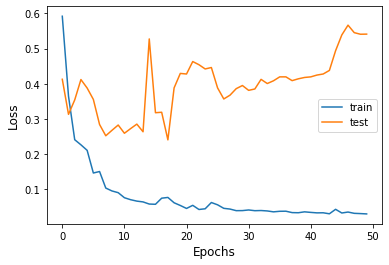

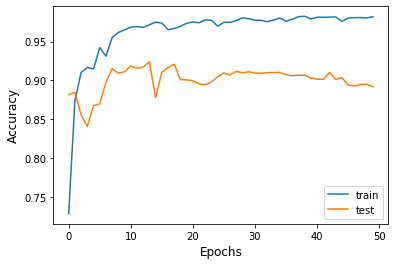

In [21]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.xlabel('Epochs', fontsize = 12)
pyplot.ylabel('Loss', fontsize = 12)
pyplot.show()
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.xlabel('Epochs', fontsize = 12)
pyplot.ylabel('Accuracy', fontsize = 12)
pyplot.show()